# Experiment 02: The Waveform Tournament

**Objective:** Determine the optimal **temporal shape** for fluid injection.

We pit three distinct parametric strategies against each other to see which waveform physics best mobilizes CO2 and prevents salt clogging:

1.  **The Hammer (Fast-Compression):** Instant rise, linear decay. Designed for *Inertial Mobilization*.
2.  **The Suction (Fast-Relaxation):** Linear rise, instant drop. Designed for *Capillary Snap-Off*.
3.  **The Chirp (Resonant Sweep):** Frequency sweep. Designed for *Acoustic Resonance*.

**Outcome:** We optimize parameters $\theta$ for each, compare the final Storage Efficiency ($S_{CO2}$), and generate detailed appendices for reporting.

In [1]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
import matplotlib.pyplot as plt
import numpy as np
import physics

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

print("Environment Configured.")

Environment Configured.


## 1. Load Baselines & Setup
We load the constant pressure baseline to calculate the relative gain of our optimized shapes.

In [2]:
try:
    baseline_data = np.load("baseline_saturation_history.npy", allow_pickle=True).item()
    baseline_curve = baseline_data['pressure_mode_saturation']
    print(f"Baseline Loaded. Final Saturation: {baseline_curve[-1]:.4f}")
except:
    print("Warning: Baseline file not found. Running without comparison.")
    baseline_curve = jnp.zeros(1000)

# Constants
TIME_STEPS = 1000
NX, NY = physics.NX, physics.NY

# Initial State (Same as Baseline)
key = jax.random.PRNGKey(42)
mask_init = jax.random.bernoulli(key, p=0.25, shape=(NX, NY)).astype(jnp.float64)
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0) 

rho_init = jnp.ones((NX, NY)) * physics.RHO_BRINE
u_init = jnp.zeros((NX, NY))
f_init = physics.get_equilibrium(rho_init, u_init, u_init)
salt_init = jnp.ones((NX, NY)) * 0.5

state_init = (f_init, salt_init, mask_init)

Baseline Loaded. Final Saturation: 0.3936


In [3]:
# --- APPENDIX A: SIMULATION CONFIGURATION ---
print("="*60)
print("       APPENDIX A: SIMULATION CONFIGURATION")
print("="*60)
print(f"1. Domain Geometry")
print(f"   - Grid Size (NX x NY):    {NX} x {NY}")
print(f"   - Total Time Steps:       {TIME_STEPS}")
print(f"   - Boundary Conditions:    Zou-He (Inlet/Outlet), Bounce-Back (Rock)")
print(f"\n2. Fluid Properties (LBM Units)")
print(f"   - Brine Density:          {physics.RHO_BRINE:.1f}")
print(f"   - Initial CO2 Density:    {physics.RHO_CO2_INIT:.1f}")
print(f"   - Relaxation Time (Brine):{physics.TAU_BRINE:.1f}")
print(f"   - Relaxation Time (CO2):  {physics.TAU_CO2:.1f}")
print(f"   - Interaction Strength G: {physics.G_INT:.1f} (Shan-Chen)")
print(f"\n3. Reactive Transport")
print(f"   - Salt Diffusion Coeff:   {physics.D_SALT:.3f}")
print(f"   - Solubility Limit (Ksp): {physics.K_SP:.1f}")
print(f"   - Precip. Rate Constant:  20.0 (Sigmoid Slope)")
print("="*60)

       APPENDIX A: SIMULATION CONFIGURATION
1. Domain Geometry
   - Grid Size (NX x NY):    100 x 50
   - Total Time Steps:       1000
   - Boundary Conditions:    Zou-He (Inlet/Outlet), Bounce-Back (Rock)

2. Fluid Properties (LBM Units)
   - Brine Density:          1.0
   - Initial CO2 Density:    0.1
   - Relaxation Time (Brine):1.0
   - Relaxation Time (CO2):  0.9
   - Interaction Strength G: -1.0 (Shan-Chen)

3. Reactive Transport
   - Salt Diffusion Coeff:   0.050
   - Solubility Limit (Ksp): 1.1
   - Precip. Rate Constant:  20.0 (Sigmoid Slope)


## 2. Define Parametric Waveforms
We define the three competing shapes as differentiable functions of time $t$ and parameters $\theta$.

In [4]:
def get_time_array(steps):
    return jnp.linspace(0, steps, steps)

# --- 1. THE HAMMER (Fast Rise, Slow Decay) ---
@jit
def waveform_hammer(t, params):
    # params: [P_base, Amplitude, Period]
    p_base, amp, period = params
    period = jnp.maximum(period, 10.0) # Avoid div by zero
    
    # Sawtooth: (1 - t/T) shape
    phase = (t % period) / period
    wave = 1.0 - phase
    return p_base + amp * wave

# --- 2. THE SUCTION (Slow Rise, Fast Decay) ---
@jit
def waveform_suction(t, params):
    # params: [P_base, Amplitude, Period]
    p_base, amp, period = params
    period = jnp.maximum(period, 10.0)
    
    # Reverse Sawtooth: (t/T) shape
    phase = (t % period) / period
    return p_base + amp * phase

# --- 3. THE CHIRP (Frequency Sweep) ---
@jit
def waveform_chirp(t, params):
    # params: [P_base, Amplitude, F_start, F_end]
    p_base, amp, f_start, f_end = params
    T_sim = float(TIME_STEPS)
    
    # Linear Chirp
    phase = 2 * jnp.pi * (f_start * t + (f_end - f_start) / (2 * T_sim) * t**2)
    # Shift Sine to be positive (0 to 1) then scale
    wave = (jnp.sin(phase) + 1.0) / 2.0
    return p_base + amp * wave

## 3. Optimization Loop (The Tournament Engine)

In [5]:
# Loss Function: Maximize Saturation => Minimize (1 - S)
def loss_fn(params, waveform_func):
    t_array = get_time_array(TIME_STEPS)
    p_schedule = waveform_func(t_array, params)
    
    # Run Physics Simulation
    final_state, (s_hist, _) = lax.scan(
        physics.lbm_step_pressure,
        state_init,
        p_schedule
    )
    
    final_saturation = s_hist[-1]
    return 1.0 - final_saturation, (s_hist, p_schedule)

def run_tournament_round(name, waveform_func, init_params, learning_rate=0.01, epochs=50):
    print(f"=== Starting Round: {name} ===")
    
    # Setup Optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(init_params)
    params = init_params
    
    best_sat = 0.0
    best_schedule = None
    best_s_curve = None
    
    # Optimization Loop
    grad_fn = value_and_grad(loss_fn, has_aux=True)
    
    for i in range(epochs):
        (loss, (s_hist, p_sched)), grads = grad_fn(params, waveform_func)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
        current_sat = 1.0 - loss
        
        if current_sat > best_sat:
            best_sat = current_sat
            best_schedule = p_sched
            best_s_curve = s_hist
            
        if i % 10 == 0:
            print(f"Epoch {i}: Saturation = {current_sat:.4f}")
            
    print(f">>> Winner of Round {name}: Final Saturation = {best_sat:.4f}\n")
    return best_s_curve, best_schedule, params


## 4. Run the Tournament

In [6]:
# 1. Hammer
init_hammer = jnp.array([0.02, 0.02, 200.0])
s_hammer, p_hammer, params_hammer = run_tournament_round(
    "The Hammer", waveform_hammer, init_hammer
)

# 2. Suction
init_suction = jnp.array([0.02, 0.02, 200.0])
s_suction, p_suction, params_suction = run_tournament_round(
    "The Suction", waveform_suction, init_suction
)

# 3. Chirp
init_chirp = jnp.array([0.02, 0.02, 0.01, 0.1])
s_chirp, p_chirp, params_chirp = run_tournament_round(
    "The Chirp", waveform_chirp, init_chirp
)

=== Starting Round: The Hammer ===
Epoch 0: Saturation = 0.3933
Epoch 10: Saturation = 0.3941
Epoch 20: Saturation = 0.3869
Epoch 30: Saturation = 0.3906
Epoch 40: Saturation = 0.3880
>>> Winner of Round The Hammer: Final Saturation = 0.3998

=== Starting Round: The Suction ===
Epoch 0: Saturation = 0.3936
Epoch 10: Saturation = 0.3910
Epoch 20: Saturation = 0.3921
Epoch 30: Saturation = 0.3913
Epoch 40: Saturation = 0.3895
>>> Winner of Round The Suction: Final Saturation = 0.3936

=== Starting Round: The Chirp ===
Epoch 0: Saturation = 0.3938
Epoch 10: Saturation = 0.3982
Epoch 20: Saturation = 0.3960
Epoch 30: Saturation = 0.3797
Epoch 40: Saturation = 0.3673
>>> Winner of Round The Chirp: Final Saturation = 0.3983



## 5. Results & Visualization

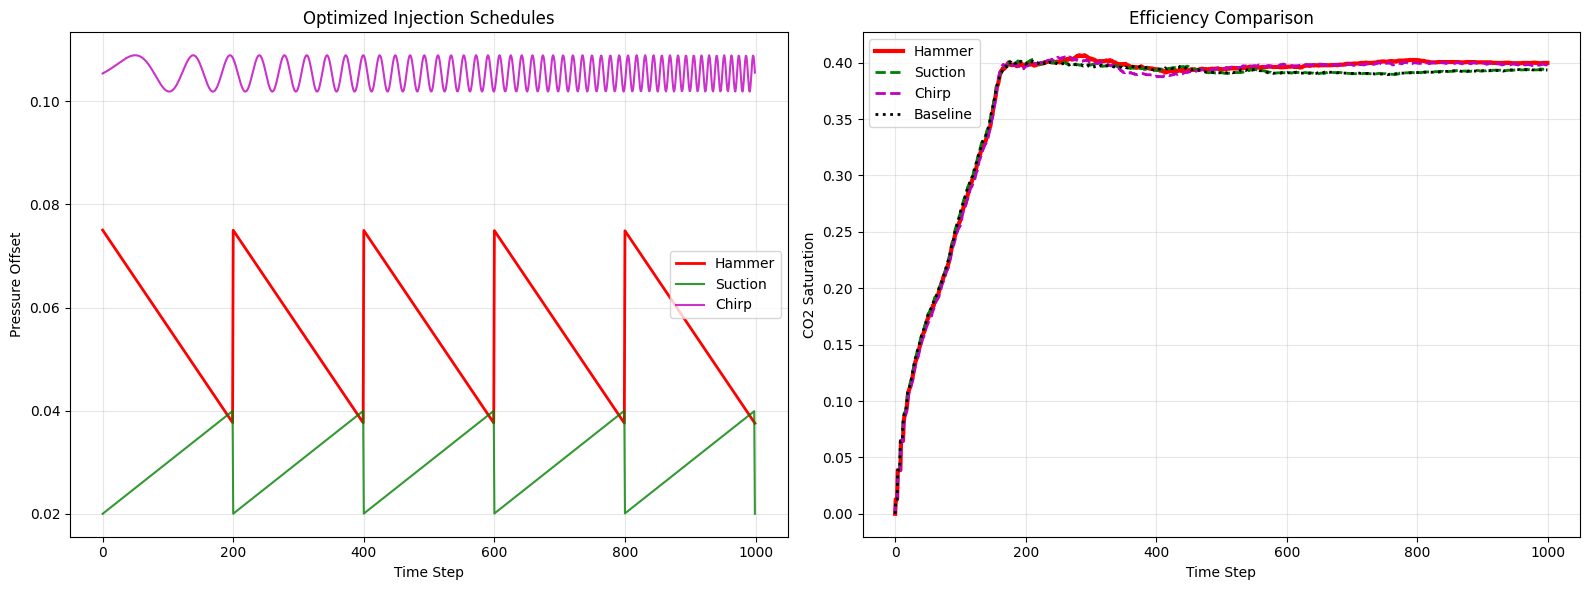

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Optimized Schedules
ax[0].plot(p_hammer, 'r-', linewidth=2, label='Hammer')
ax[0].plot(p_suction, 'g-', linewidth=1.5, alpha=0.8, label='Suction')
ax[0].plot(p_chirp, 'm-', linewidth=1.5, alpha=0.8, label='Chirp')
ax[0].set_title("Optimized Injection Schedules")
ax[0].set_ylabel("Pressure Offset")
ax[0].set_xlabel("Time Step")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot 2: Saturation History
ax[1].plot(s_hammer, 'r-', linewidth=3, label='Hammer')
ax[1].plot(s_suction, 'g--', linewidth=2, label='Suction')
ax[1].plot(s_chirp, 'm--', linewidth=2, label='Chirp')
ax[1].plot(baseline_curve, 'k:', linewidth=2, label='Baseline')
ax[1].set_title("Efficiency Comparison")
ax[1].set_ylabel("CO2 Saturation")
ax[1].set_xlabel("Time Step")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# --- APPENDIX B: OPTIMIZED RESULTS SUMMARY ---
print("="*60)
print("       APPENDIX B: OPTIMIZED RESULTS SUMMARY")
print("="*60)

def print_results(name, params, sat, labels):
    print(f"{name.upper()}:")
    print(f"   Final Saturation:    {sat:.4f}")
    improvement = (sat - baseline_curve[-1]) / baseline_curve[-1] * 100
    print(f"   Improvement vs Base: {improvement:+.2f}%")
    print("   Optimized Parameters:")
    for label, val in zip(labels, params):
        print(f"      - {label:<15} {val:.5f}")
    print("-"*60)

print_results("1. The Hammer", params_hammer, s_hammer[-1], ["P_base", "Amplitude", "Period"])
print_results("2. The Suction", params_suction, s_suction[-1], ["P_base", "Amplitude", "Period"])
print_results("3. The Chirp", params_chirp, s_chirp[-1], ["P_base", "Amplitude", "F_start", "F_end"])
print(f"BASELINE SATURATION:    {baseline_curve[-1]:.4f}")
print("="*60)

       APPENDIX B: OPTIMIZED RESULTS SUMMARY
1. THE HAMMER:
   Final Saturation:    0.3998
   Improvement vs Base: +1.57%
   Optimized Parameters:
      - P_base          0.11370
      - Amplitude       0.11163
      - Period          200.14060
------------------------------------------------------------
2. THE SUCTION:
   Final Saturation:    0.3936
   Improvement vs Base: -0.00%
   Optimized Parameters:
      - P_base          0.04783
      - Amplitude       0.06405
      - Period          199.48577
------------------------------------------------------------
3. THE CHIRP:
   Final Saturation:    0.3983
   Improvement vs Base: +1.19%
   Optimized Parameters:
      - P_base          0.25616
      - Amplitude       0.06953
      - F_start         -0.00187
      - F_end           0.09650
------------------------------------------------------------
BASELINE SATURATION:    0.3936


## 6. Fluid Map Visualization
Comparison of the reservoir state before injection vs. after the optimal "Hammer" strategy.

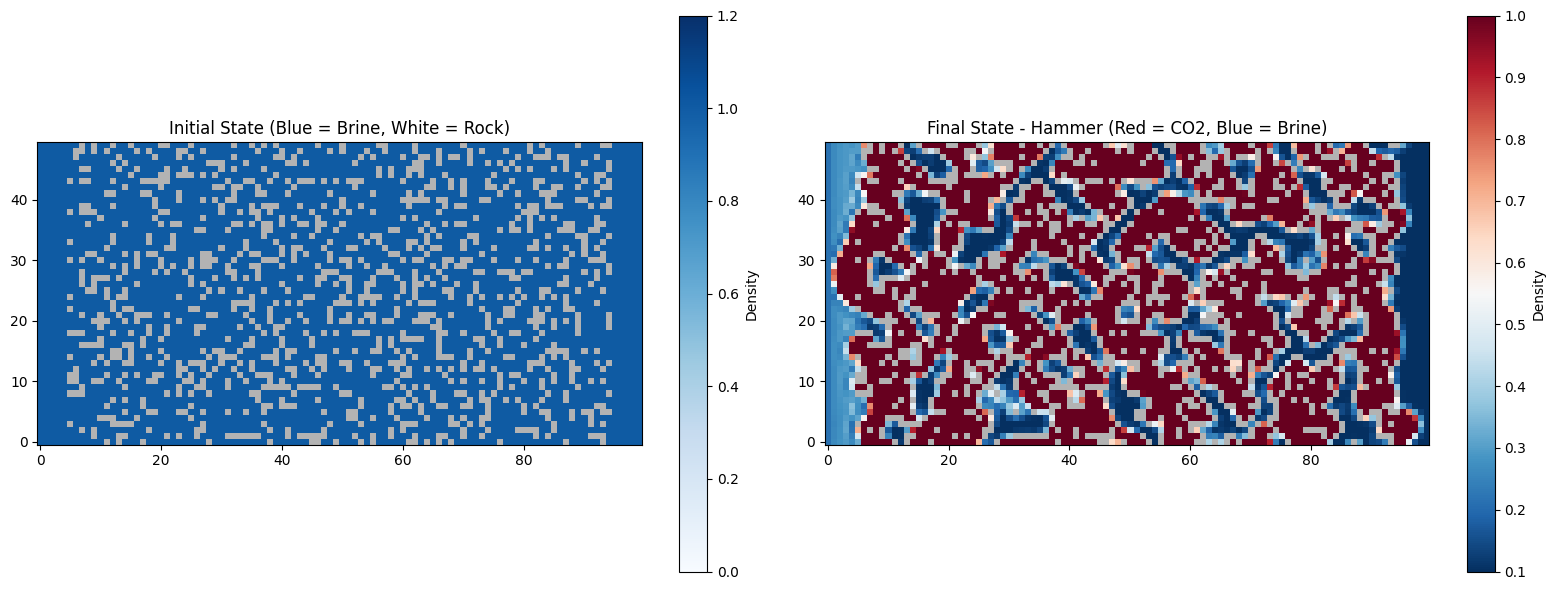

In [9]:
# Re-run the WINNER (Hammer) to get the final fluid state
t_array = get_time_array(TIME_STEPS)
p_schedule_winner = waveform_hammer(t_array, params_hammer)

final_state_winner, _ = lax.scan(
    physics.lbm_step_pressure,
    state_init,
    p_schedule_winner
)

f_final, salt_final, mask_final = final_state_winner
rho_final = jnp.sum(f_final, axis=-1)

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Initial State
f_init, _, mask_init_val = state_init
rho_init_val = jnp.sum(f_init, axis=-1)
# Mask out the rock for cleaner plotting
rho_init_masked = np.ma.masked_where(mask_init_val > 0.5, rho_init_val)

ax[0].imshow(mask_init_val.T, cmap='gray_r', origin='lower', alpha=0.3)
im0 = ax[0].imshow(rho_init_masked.T, cmap='Blues', origin='lower', vmin=0.0, vmax=1.2)
ax[0].set_title("Initial State (Blue = Brine, White = Rock)")
plt.colorbar(im0, ax=ax[0], label="Density")

# 2. Final State (Hammer)
rho_final_masked = np.ma.masked_where(mask_final > 0.5, rho_final)

ax[1].imshow(mask_final.T, cmap='gray_r', origin='lower', alpha=0.3)
# Use a diverging colormap: Blue (Brine) -> Red (CO2)
im1 = ax[1].imshow(rho_final_masked.T, cmap='RdBu_r', origin='lower', vmin=physics.RHO_CO2_INIT, vmax=physics.RHO_BRINE)
ax[1].set_title("Final State - Hammer (Red = CO2, Blue = Brine)")
plt.colorbar(im1, ax=ax[1], label="Density")

plt.tight_layout()
plt.show()